In experiment 1.2 we employed five high pass filters in the first (preprocessing) layer in our model. These filters were the following.

<ul>
<li>5x5 laplacian kernel</li>
<li>5x5 Sobel X kernel</li>
<li>5x5 Sobel Y kernel</li>
<li>5x5 Prewitt X kernel</li>
<li>5x5 Prewitt Y kernel</li>
</ul>

In this experiment, for our first layer filters we will use the 20 filters that have been used for Robust Median Filtering by Yu et al.(link to paper can be found [here](https://sci-hub.se/10.1109/ACCESS.2019.2932810))

# Dataset-Download

In [ ]:
from IPython.display import clear_output
!pip install -q kaggle
!mkdir ~/.kaggle/
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d bibhash123/djpeg-ex1p3
!unzip djpeg-ex1p3.zip -d '/content/DCR/'
clear_output(wait=False)

In [ ]:
! git clone https://github.com/Bibhash123/Resizing_Forensics.git

Cloning into 'Resizing_Forensics'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 47 (delta 12), reused 8 (delta 1), pack-reused 0
Unpacking objects: 100% (47/47), done.


# Model Preparation

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K

In [ ]:
PATH = '/content/DCR/'
factor = lambda x: x.split('.jpg')[0].split('rf_')[-1]

## Filter Layer

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
class PreprocessLayer(L.Layer):
  def __init__(self,**kwargs):
    super(PreprocessLayer,self).__init__(**kwargs)
  
  def build(self,input_shape):
    self.built=True
  #filter definitions
  #first third and second defined....to define sq and edge
  #elementary filters  
  def a1(self,image):
    filter = K.constant(np.array([[[[0,0,0,0,0],
                        [0,0,0,0,0],
                        [0,0,-1,1,0],
                        [0,0,0,0,0],
                        [0,0,0,0,0]]]]).reshape((5,5,1,1)))
    return K.conv2d(image,filter,padding='same')
  
  def lin_vertical(self,image):
    filter = K.constant(np.array([[[[0,0,0,0,0],
                        [0,0,1,0,0],
                        [0,0,-1,0,0],
                        [0,0,0,0,0],
                        [0,0,0,0,0]]]]).reshape((5,5,1,1)))
    return K.conv2d(image,filter,padding='same')
  
  def lin_horizontal(self,image):
    filter = K.constant(np.array([[[[0,0,0,0,0],
                        [0,0,0,0,0],
                        [0,1,-1,0,0],
                        [0,0,0,0,0],
                        [0,0,0,0,0]]]]).reshape((5,5,1,1)))
    return K.conv2d(image,filter,padding='same')
  
  def a2(self,image):
    filter = K.constant(np.array([[[[0,0,0,0,0],
                        [0,0,0,0,0],
                        [0,1,-2,1,0],
                        [0,0,0,0,0],
                        [0,0,0,0,0]]]]).reshape((5,5,1,1)))
    return K.conv2d(image,filter,padding='same')
  
  def ord2_vertical(self,image):
    filter = K.constant(np.array([[[[0,0,0,0,0],
                        [0,0,1,0,0],
                        [0,0,-2,0,0],
                        [0,0,1,0,0],
                        [0,0,0,0,0]]]]).reshape((5,5,1,1)))
    return K.conv2d(image,filter,padding='same')

  def a3(self,image):
    filter = K.constant(np.array([[[[0,0,0,0,0],
                        [0,0,0,0,0],
                        [0,1,-3,3,-1],
                        [0,0,0,0,0],
                        [0,0,0,0,0]]]]).reshape((5,5,1,1)))
    return K.conv2d(image,filter,padding='same')
  
  def ord3_horizontal(self,image):
    filter = K.constant(np.array([[[[0,0,0,0,0],
                        [0,0,0,0,0],
                        [-1,3,-3,1,0],
                        [0,0,0,0,0],
                        [0,0,0,0,0]]]]).reshape((5,5,1,1)))
    return K.conv2d(image,filter,padding='same')
  
  def ord3_vertical(self,image):
    filter = K.constant(np.array([[[[0,0,-1,0,0],
                        [0,0,3,0,0],
                        [0,0,-3,0,0],
                        [0,0,1,0,0],
                        [0,0,0,0,0]]]]).reshape((5,5,1,1)))
    return K.conv2d(image,filter,padding='same')

  #minmax filters
  def b1(self,image):
    return K.minimum(self.a1(image),self.lin_horizontal(image))
  
  def c1(self,image):
    return K.minimum(self.a1(image),self.lin_vertical(image))
  
  def d1(self,image):
    return K.minimum(self.c1(image),self.lin_horizontal(image))
  
  def b2(self,image):
    return K.minimum(self.a2(image),self.ord2_vertical(image))
  
  def b3(self,image):
    return K.minimum(self.a3(image),self.ord3_horizontal(image))
  
  def c3(self,image):
    return K.minimum(self.a3(image),self.ord3_vertical(image))
  
  def d3(self,image):
    return K.minimum(self.c3(image),self.ord3_horizontal(image))
  
  #square filters
  def s3a(self,image):
    filter = K.constant(np.array([[[[0,0,0,0,0],
                        [0,-1,2,-1,0],
                        [0,2,-4,2,0],
                        [0,-1,2,-1,0],
                        [0,0,0,0,0]]]]).reshape((5,5,1,1)))
    return K.conv2d(image,filter,padding='same')
  
  def s5a(self,image):
    filter = K.constant(np.array([[[[-1,2,-2,2,-1],
                        [2,-6,8,-6,2],
                        [-2,8,-12,8,-2],
                        [2,-6,8,-6,2],
                        [-1,2,-2,2,-1]]]]).reshape((5,5,1,1)))
    return K.conv2d(image,filter,padding='same')
  
  #edge filters
  def e3_vertical_l(self,image):
    filter = K.constant(np.array([[[[0,0,0,0,0],
                        [0,-1,2,0,0],
                        [0,2,-4,0,0],
                        [0,-1,2,0,0],
                        [0,0,0,0,0]]]]).reshape((5,5,1,1)))
    return K.conv2d(image,filter,padding='same')
  
  def e3_horizontal(self,image):
    filter = K.constant(np.array([[[[0,0,0,0,0],
                        [0,0,0,0,0],
                        [0,2,-4,2,0],
                        [0,-1,2,-1,0],
                        [0,0,0,0,0]]]]).reshape((5,5,1,1)))
    return K.conv2d(image,filter,padding='same')

  def e3_vertical_r(self,image):
    filter = K.constant(np.array([[[[0,0,0,0,0],
                        [0,0,2,-1,0],
                        [0,0,-4,2,0],
                        [0,0,2,-1,0],
                        [0,0,0,0,0]]]]).reshape((5,5,1,1)))
    return K.conv2d(image,filter,padding='same')
  
  def e3a(self,image):
    filter = K.constant(np.array([[[[0,0,0,0,0],
                        [0,-1,2,-1,0],
                        [0,2,-4,2,0],
                        [0,0,0,0,0],
                        [0,0,0,0,0]]]]).reshape((5,5,1,1)))
    return K.conv2d(image,filter,padding='same')
  
  def e3b(self,image):
    return K.minimum(self.e3a(image),self.e3_vertical_l(image))
  
  def e3c(self,image):
    return K.minimum(self.e3a(image),self.e3_horizontal(image))
  
  def e3d(self,image):
    return K.minimum(self.e3c(image),K.minimum(self.e3_vertical_l(image),self.e3_vertical_r(image)))
  
  def e5_vertical_l(self,image):
    filter = K.constant(np.array([[[[-1,2,-2,0,0],
                        [2,-6,8,0,0],
                        [-2,8,-12,0,0],
                        [2,-6,8,0,0],
                        [-1,2,-2,0,0]]]]).reshape((5,5,1,1)))
    return K.conv2d(image,filter,padding='same')
  
  def e5_vertical_r(self,image):
    filter = K.constant(np.array([[[[0,0,-2,2,-1],
                        [0,0,8,-6,2],
                        [0,0,-12,8,-2],
                        [0,0,8,-6,2],
                        [0,0,-2,2,-1]]]]).reshape((5,5,1,1)))
    return K.conv2d(image,filter,padding='same')
  
  def e5_horizontal(self,image):
    filter = K.constant(np.array([[[[0,0,0,0,0],
                        [0,0,0,0,0],
                        [-2,8,-12,8,-2],
                        [2,-6,8,-6,2],
                        [-1,2,-2,2,-1]]]]).reshape((5,5,1,1)))
    return K.conv2d(image,filter,padding='same')
  
  def e5a(self,image):
    filter = K.constant(np.array([[[[-1,2,-2,2,-1],
                        [2,-6,8,-6,2],
                        [-2,8,-12,8,-2],
                        [0,0,0,0,0],
                        [0,0,0,0,0]]]]).reshape((5,5,1,1)))
    return K.conv2d(image,filter,padding='same')
  
  def e5b(self,image):
    return K.minimum(self.e5a(image),self.e5_vertical_l(image))
  
  def e5c(self,image):
    return K.minimum(self.e5a(image),self.e5_horizontal(image))
  
  def e5d(self,image):
    return K.minimum(self.e5c(image),K.minimum(self.e5_vertical_l(image),self.e5_vertical_r(image)))

  # refer TIFS-SRM 2012 paper to understand filters (Page No 5)
  def call(self,image):
    return K.stack([self.a1(image)[:,:,:,0],             #corresponds 1a)
                                self.b1(image)[:,:,:,0], #corresponds 1b)
                                self.c1(image)[:,:,:,0], #corresponds 1c)
                                self.d1(image)[:,:,:,0], #corresponds 1d)
                                self.a2(image)[:,:,:,0], #corresponds 2a)
                                self.b2(image)[:,:,:,0], #corresponds 2b)
                                self.a3(image)[:,:,:,0], #corresponds 3rd order defined similar to 1a)
                                self.b3(image)[:,:,:,0], #corresponds 3rd order defined similar to 1b)
                                self.c3(image)[:,:,:,0], #corresponds 3rd order defined similar to 1c)
                                self.d3(image)[:,:,:,0], #corresponds 3rd order defined similar to 1d)
                                self.s3a(image)[:,:,:,0],#square 3x3 refer S3a)
                                self.s5a(image)[:,:,:,0],#square 5x5 refer S5a)
                                self.e3a(image)[:,:,:,0],#edge 3x3 refer E3a)
                                self.e3b(image)[:,:,:,0],#edge 3x3 refer E3b)
                                self.e3c(image)[:,:,:,0],#edge 3x3 refer E3c)
                                self.e3d(image)[:,:,:,0],#edge 3x3 refer E3d)
                                self.e5a(image)[:,:,:,0],#edge 5x5 similar to E3a)
                                self.e5b(image)[:,:,:,0],#edge 5x5 similar to E3a)
                                self.e5c(image)[:,:,:,0],#edge 5x5 similar to E3a)
                                self.e5d(image)[:,:,:,0],#edge 5x5 similar to E3a)
                                ],axis=3)
  def get_output_shape(self,input_shape):
    return (input_shape[0],input_shape[1],input_shape[2],20)

In [ ]:
class ConvConst(tf.keras.models.Model):
  def __init__(self,num_classes=10):
    super(ConvConst,self).__init__()
    self.n_classes = num_classes
    #self.block1 = PreprocessLayer()
    
    self.block2 = tf.keras.models.Sequential([
                                              L.Conv2D(96,(7,7),strides=2),
                                              L.BatchNormalization(),
                                              L.Activation('tanh'),
                                              L.MaxPool2D(pool_size=(3,3),strides=2)
    ])
    self.block3 = tf.keras.models.Sequential([
                                             L.Conv2D(64,(5,5),strides=1),
                                             L.BatchNormalization()
    ])
    self.block4 = tf.keras.models.Sequential([
                                             L.Conv2D(64,(5,5),strides=1),
                                             L.BatchNormalization(),
                                             L.Activation('tanh'),
                                             L.MaxPool2D(pool_size=(3,3),strides=2)
    ])
    self.block5 = tf.keras.models.Sequential([
                                             L.Conv2D(128,(1,1),strides=1),
                                             L.BatchNormalization(),
                                             L.Activation('tanh'),
                                             L.AveragePooling2D(pool_size=(3,3),strides=2)
    ])

    self.fc1 = L.Dense(200)
    self.fc2 = L.Dense(200)
    self.fc3 = L.Dense(num_classes,activation="softmax")

  def call(self,inputs,**kwargs):
    #out = self.block1(inputs)
    out = self.block2(inputs)
    out = self.block3(out)
    out = self.block4(out)
    out = self.block5(out)

    out = L.Flatten()(out)

    out = self.fc1(out)
    out = self.fc2(out)
    out = self.fc3(out)
    return out

In [ ]:
K.clear_session()
model = ConvConst(num_classes=10)
model.compile(loss = 'sparse_categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),metrics=["accuracy"])
model.build((None,256,256,1))

model.layers[0].trainable=False

In [ ]:
model.summary()

Model: "conv_const"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 62, 62, 96)        5184      
                                                                 
 sequential_1 (Sequential)   (None, 58, 58, 64)        153920    
                                                                 
 sequential_2 (Sequential)   (None, 26, 26, 64)        102720    
                                                                 
 sequential_3 (Sequential)   (None, 12, 12, 128)       8832      
                                                                 
 dense (Dense)               multiple                  3686600   
                                                                 
 dense_1 (Dense)             multiple                  40200     
                                                                 
 dense_2 (Dense)             multiple                  2

In [ ]:
#import sys
#del sys.modules["DataLoader"]
#del sys.modules["const"]

# Model Training

In [ ]:
from DataLoader import *
from const import loss_plt

In [ ]:
RF = [0.6,0.7,0.8,0.9,0.95,1.05,1.1,1.2,1.3,1.4]

In [ ]:
load = DataLoader(path ='/content/DCR/train/',val_path = '/content/DCR/val/',merge=False,rfs =RF)

train = load.flow(batch_size=64)
val = load.val_flow(batch_size=64)
   
#early stopping            
early_stop = tf.keras.callbacks.EarlyStopping(patience=10,monitor='val_accuracy',mode='max')
#loss curves and log writing
loss_plot = loss_plt()
#check point
chckpt = tf.keras.callbacks.ModelCheckpoint('model.hdf5',monitor='val_accuracy',mode='max',save_best_only=True,save_weights_only=True)
lr_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',mode='min',patience=5,factor=0.8)

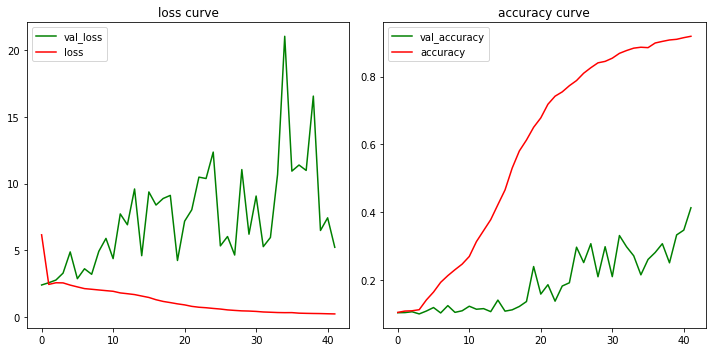

epoch 42/50 loss: 0.247 accuracy: 0.9190 val_loss: 5.235 val_accuracy:0.4126
412/412 [==============================] - 510s 1s/step - loss: 0.2475 - accuracy: 0.9190 - val_loss: 5.2345 - val_accuracy: 0.4126 - lr: 5.0332e-04
Epoch 43/50
342/412 [=======================>......] - ETA: 1:18 - loss: 0.2365 - accuracy: 0.9208

In [ ]:
model.fit(train,
          steps_per_epoch = int(len(load.files)/64),
          epochs = 50,
          validation_data = val,
          validation_steps= int(len(load.val_files)/64),
          callbacks=[loss_plot,chckpt,lr_plateau],
          verbose=1
          )

# Model-Testing

In [ ]:
~q      model.load_weights('model.hdf5')

In [ ]:
import glob
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score

In [ ]:
files = [fn for fn in glob.glob(os.path.join('/content/DCR/test','*.jpg'))]

In [ ]:
def crop_image(img):
    mid = (int(img.shape[0]/2),int(img.shape[1]/2))
    return img[mid[0]-128:mid[0]+128,mid[1]-128:mid[1]+128]

class_dict = dict(zip(RF,range(len(RF))))
label = lambda x: class_dict[float(x.split('.jpg')[0].split('rf_')[-1])]

images = []
labels = []
for f in tqdm(files):
  image = cv2.cvtColor(cv2.imread(f),cv2.COLOR_BGR2GRAY)
  image = np.expand_dims(crop_image(image),axis=2).astype(np.float32)
  labels.append(label(f.split('/')[-1]))
  images.append(image)
  

In [1]:
pred = [np.argmax(p) for p in model.predict(np.stack(images))]
accuracy_score(labels,pred)

0.4036363636363636

In [ ]:

from accuracyMatrix_1 import matrix
from utilities import *


Mounted at /content/gdrive


## All-Factors